In [1]:
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries
from tsx.xai import evaluation as eva

from data_util import *
from viz import *

import itertools
import pandas as pd
from biokit.viz import corrplot

### Objectives
1. Evaluate between different XAI models but same family (Ridge, for example)
1. Evaluate between different DL model, but same XAI model
1. Evaluate the same on Multivariate Time Series
1. (Todo) -> Evaluate the same on Univariate Time Series

### Metrics to Evaluation
1. coef correlations
1. r2-scores
    the scores when building XAI model in approximation process $f(z) ~ g(z') = w * z'$


## Prepare Data Set

In [3]:
import numpy as np
import pandas as pd
from data_util import *

independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)
samples_size = 100

df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)
df[independents] = x_scaler.transform(df[independents].values)
df[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))

In [4]:
from random import shuffle

indices = [i for i in range(len(df) - 129)]
train, test = np.split(indices, [int(len(indices)*0.8)])

X = []
y = []
for index in train:
    X.append(df.iloc[index:index+n_steps][independents].values)
    y.append(df.iloc[index+n_steps][dependent])
    
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)


X_test = []
y_test = []
for index in test:
    X_test.append(df.iloc[index:index+n_steps][independents].values)
    y_test.append(df.iloc[index+n_steps][dependent])
    
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34936, 128, 7) (34936,)
(8735, 128, 7) (8735,)


In [5]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"data/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"data/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z_reshaped = z.T.reshape(1, 128, 7)
    z_hat = model.predict(z_reshaped)
    # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

def lstm_fn(z):
    return predict_fn(z, model=lstm)

def wavenet_fn(z):
    return predict_fn(z, model=wavenet)

In [6]:
# Prepare Params for different models
scales = ["async", "sync"]
repl_fn = ["zeros", "local_mean", "global_mean"]
model_fn = ["lstm", "wavenet"]

params = list(itertools.product(scales, repl_fn, model_fn))
params_df = pd.DataFrame([{"scale": s, "method": m, "model":model} for s, m, model in params])
# print(params_df)
params_df.style\
    .apply(lambda s: ['background-color: %s' % ('grey' if v else '') for v in s == "async"]) \
    .apply(lambda s: ['background-color: %s' % ('green' if v else '') for v in s == "sync"]) \
    .applymap(lambda s: 'color: %s' % ('cyan' if s == "lstm_fn" else '' )) \
    .applymap(lambda s: 'color: %s' % ('orange' if s == "wavenet_fn" else '' ))

,scale,method,model
0,async,zeros,lstm
1,async,zeros,wavenet
2,async,local_mean,lstm
3,async,local_mean,wavenet
4,async,global_mean,lstm
5,async,global_mean,wavenet
6,sync,zeros,lstm
7,sync,zeros,wavenet
8,sync,local_mean,lstm
9,sync,local_mean,wavenet


In [7]:
def get_xcoef_and_r2_score(X, scale="async", method="zeros", model="lstm", **kwargs):
    lime_ts = LIMETimeSeries(scale=scale, perturb_method=method, **kwargs)
    lime_ts.explain_instances(X, predict_fn=eval(f"{model}_fn"))
    coef = lime_ts.coef
    x_coef = lime_ts.perturb_obj._x_masked(X[0], coef)
    s = lime_ts.score
    return x_coef, s

In [31]:
from tqdm.notebook import tqdm
import time
# Generate explanations for each option
# X_test 
# y_test
N = 20
X = np.array([x.T for x in X_test[:N]])
explanations = []
for p in params:   # scale, method, model
    print("Generating explanations for: ", p)

    time.sleep(1)
    # sample_size = 200 if p[0] == 'sync' else 500 
    sample_size = 100   
    x_coef, r2_score = get_xcoef_and_r2_score(X, p[0], p[1], p[2])  # multiple-averaging explanation
    d = {"scale": p[0], "method": p[1], "model": p[2], 
        "x_coef": x_coef, "r2": r2_score}
    explanations.append(d)

    time.sleep(1)
    print("Done")

Generating explanations for:  ('async', 'zeros', 'lstm')
Done
Generating explanations for:  ('async', 'zeros', 'wavenet')
Done
Generating explanations for:  ('async', 'local_mean', 'lstm')
Done
Generating explanations for:  ('async', 'local_mean', 'wavenet')
Done
Generating explanations for:  ('async', 'global_mean', 'lstm')
Done
Generating explanations for:  ('async', 'global_mean', 'wavenet')
Done
Generating explanations for:  ('sync', 'zeros', 'lstm')
Done
Generating explanations for:  ('sync', 'zeros', 'wavenet')
Done
Generating explanations for:  ('sync', 'local_mean', 'lstm')
Done
Generating explanations for:  ('sync', 'local_mean', 'wavenet')
Done
Generating explanations for:  ('sync', 'global_mean', 'lstm')
Done
Generating explanations for:  ('sync', 'global_mean', 'wavenet')
Done


In [33]:
exp_df = pd.DataFrame(explanations)
exp_df

,scale,method,model,x_coef,r2
0,async,zeros,lstm,"[[-0.2506360263681092, -0.2506360263681092, 1....",-2.111458
1,async,zeros,wavenet,"[[1.2022427269692604, 1.2022427269692604, -2.9...",-7.877378
2,async,local_mean,lstm,"[[0.2973502848363031, 0.2973502848363031, -0.1...",-3.326236
3,async,local_mean,wavenet,"[[0.16261430181711164, 0.16261430181711164, -0...",-6.776944
4,async,global_mean,lstm,"[[0.14640144819880413, 0.14640144819880413, -1...",-1.373755
5,async,global_mean,wavenet,"[[-0.94226605355112, -0.94226605355112, -2.084...",-8.354220
6,sync,zeros,lstm,"[[2.7268408777790745, 2.7268408777790745, 0.85...",-10.049315
7,sync,zeros,wavenet,"[[6.281482602420937, 6.281482602420937, 5.1494...",-5.952349
8,sync,local_mean,lstm,"[[-0.5635766329107439, -0.5635766329107439, 0....",-16.092256
9,sync,local_mean,wavenet,"[[1.3103465547604773, 1.3103465547604773, -1.5...",-1.340460


In [46]:
# Correlation Matrix
names = exp_df["scale"] + "-" + exp_df["method"] + "-" + exp_df["model"]
xcoefs = exp_df["x_coef"].apply(np.ravel)
coefs_corr = eva.corr_matrix(list(xcoefs), names)


,async-zeros-lstm,async-local_mean-lstm,async-global_mean-lstm,sync-zeros-lstm,sync-local_mean-lstm,sync-global_mean-lstm
async-zeros-lstm,1.000000,0.134896,0.626182,0.193865,0.203423,0.239320
async-local_mean-lstm,0.134896,1.000000,0.149657,0.124805,0.158281,0.271618
async-global_mean-lstm,0.626182,0.149657,1.000000,0.194014,0.188100,0.251445
sync-zeros-lstm,0.193865,0.124805,0.194014,1.000000,0.402862,0.568148
sync-local_mean-lstm,0.203423,0.158281,0.188100,0.402862,1.000000,0.513474
sync-global_mean-lstm,0.239320,0.271618,0.251445,0.568148,0.513474,1.000000


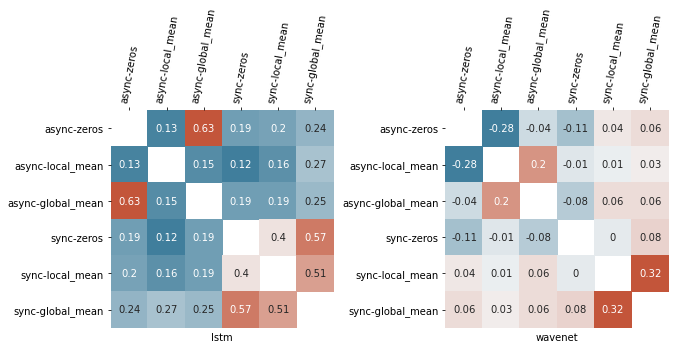

In [153]:
import seaborn as sns
_ = labels.str.contains("lstm")
_df = coefs_corr.loc[_, _].round(2)
_df.columns = [str(s).replace("-lstm", "") for s in _df.columns]
_df.index = [str(s).replace("-lstm", "") for s in _df.index]

_2 = labels.str.contains("wavenet")
_df2 = coefs_corr.loc[_2, _2].round(2)
_df2.columns = [str(s).replace("-wavenet", "") for s in _df.columns]
_df2.index = [str(s).replace("-wavenet", "") for s in _df.index]

mask = np.ones_like(_df)
mask = np.triu(mask) * np.triu(mask).T

fig, axes = plt.subplots(1,2, figsize = (10, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = axes[0]
sns.heatmap(_df, mask=mask, cmap=cmap, annot=True, cbar=False, ax=ax)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('lstm')
for tick in ax.get_xticklabels():
    tick.set_rotation(80)

ax = axes[1]
sns.heatmap(_df2, mask=mask, cmap=cmap, annot=True, cbar=False, ax=ax)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('wavenet')
for tick in ax.get_xticklabels():
    tick.set_rotation(80)
plt.subplots_adjust(wspace=0.5)


In [154]:
exp_df.loc[:, ["scale", "method", "model", "r2"]]

,scale,method,model,r2
0,async,zeros,lstm,-2.111458
1,async,zeros,wavenet,-7.877378
2,async,local_mean,lstm,-3.326236
3,async,local_mean,wavenet,-6.776944
4,async,global_mean,lstm,-1.373755
5,async,global_mean,wavenet,-8.354220
6,sync,zeros,lstm,-10.049315
7,sync,zeros,wavenet,-5.952349
8,sync,local_mean,lstm,-16.092256
9,sync,local_mean,wavenet,-1.340460
